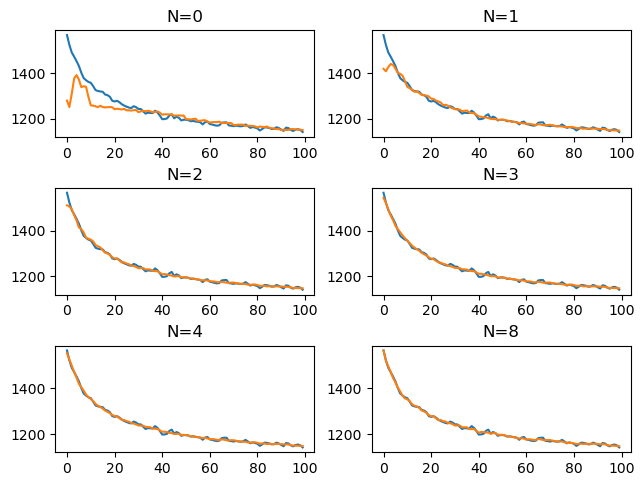

In [101]:
"""
Notebook for visualizing different order polynomial differences
"""


#Define imports
from scipy.io import loadmat
from scipy import signal
from scipy import interpolate
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings


#########################
Cmax=100
uVpc = 1e6 * (10e-3 / (2**24))

nstep_off=5
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60 #
#Andy sets navg (spectrum time windowing) to 120
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#These are the files used for generation for 12/xx/22 committee meeting presentation
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-efr.mat"
#gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-gps.mat"
#ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0042-ctd.mat"

#try a different set for a bad spectrum
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0061-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0061-ctd.mat"


EFR = loadmat(fname)




efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)


ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)
func = interpolate.interp1d(ctd_time, P, fill_value="extrapolate")

#Pef = Pef-5

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)


fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];


Nfit_arr = [0, 1, 2, 3, 4, 8]
plt.figure()
count =1
for Nfit in Nfit_arr:
    
    #Do the 50s fits 
    [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

    #Get overall fi and calculate the residuals
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        e1off=np.nanmean(e1offs,1);
        e2off=np.nanmean(e2offs,1);
        e1fit=np.nanmean(e1fits,1);
        e2fit=np.nanmean(e2fits,1);
    
    plt.subplot(3, 2, count)
    plt.plot(E2[:100])
    plt.plot(e2fit[:100])
    plt.title("N="+str(Nfit))
    
    count+=1
plt.tight_layout(pad=0.5)
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/1Hz_flowchart_figs/voltage_fits_varying_N.png")


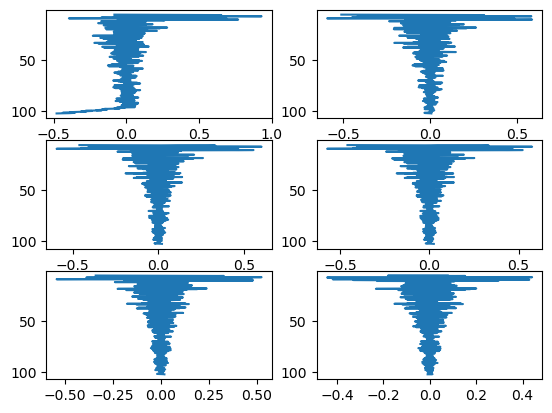

In [13]:
count=1
for Nfit in Nfit_arr:
    
    #Do the 50s fits 
    [e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

    #Get overall fi and calculate the residuals
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        e1off=np.nanmean(e1offs,1);
        e2off=np.nanmean(e2offs,1);
        e1fit=np.nanmean(e1fits,1);
        e2fit=np.nanmean(e2fits,1);
    
    plt.subplot(3, 2, count)
    plt.plot((E2-e2fit)*sfv2, Pef)
    plt.gca().invert_yaxis()

    
    count+=1

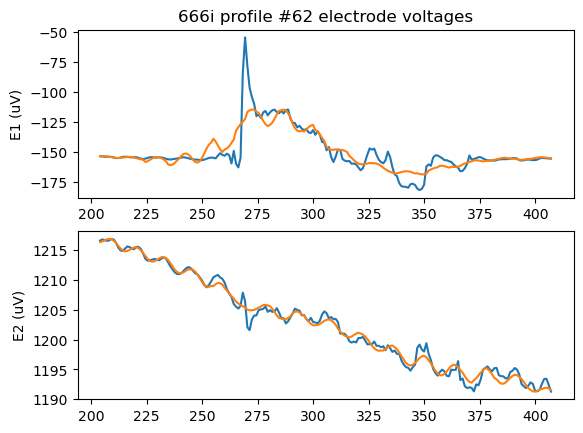

In [39]:
#Do the 50s fits 
[e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(1,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

#Get overall fi and calculate the residuals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    e1off=np.nanmean(e1offs,1);
    e2off=np.nanmean(e2offs,1);
    e1fit=np.nanmean(e1fits,1);
    e2fit=np.nanmean(e2fits,1);

sind = 200
find = 400
plt.subplot(212)
plt.plot(mlt_efr[sind:find]-mlt_efr[0], E2[sind:find])
plt.plot(mlt_efr[sind:find]-mlt_efr[0], e2fit[sind:find])
plt.ylabel("E2 (uV)")
plt.subplot(211)
plt.plot(mlt_efr[sind:find]-mlt_efr[0], E1[sind:find])
plt.plot(mlt_efr[sind:find]-mlt_efr[0], e1fit[sind:find])
plt.ylabel("E1 (uV)")
plt.title("666i profile #62 electrode voltages")
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/6667i_62/electrode_voltages.png")

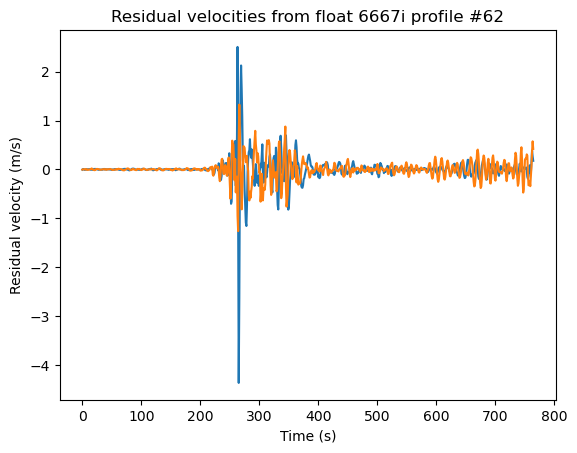

In [41]:
 #Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to velocity (m/s)
e1r = e1r*sfv1
e2r = e2r*sfv2


#Now use the angles to rotate to x-y coordinates
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r
E_y = E2_r

#Now try highpass filtering the data
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)

E_x = E_x_filtered
E_y = E_y_filtered

plt.plot(E_x)
plt.plot(E_y)
plt.ylabel("Residual velocity (m/s)")
plt.xlabel("Time (s)")
plt.title("Residual velocities from float 6667i profile #62")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/6667i_62/residual_velocities.png")

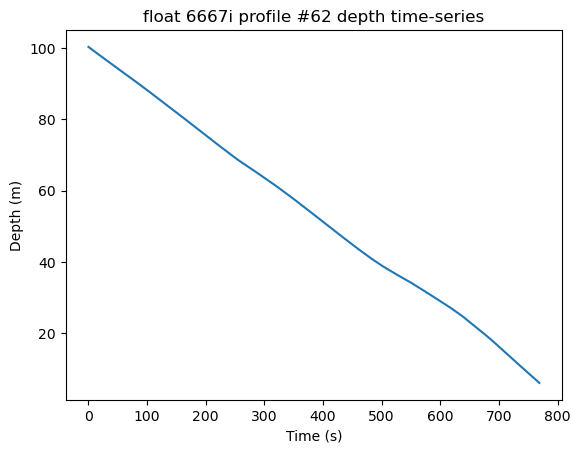

In [45]:
plt.plot(Pef)
plt.xlabel("Time (s)")
plt.ylabel("Depth (m)")
plt.title("float 6667i profile #62 depth time-series")
plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/6667i_62/depth_time_series.png")

1490971807.9007182
1490971808.0


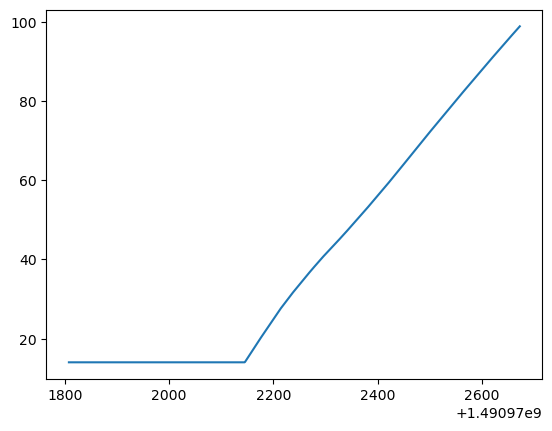

In [102]:
plt.plot(mlt_efr, Pef)

print(mlt_efr[0])
print(efr_times[0])


In [97]:
print(Pef)

[ 8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812  8.11132812
  8.11132812  8.11132812  8.11132812  8.11132812  8

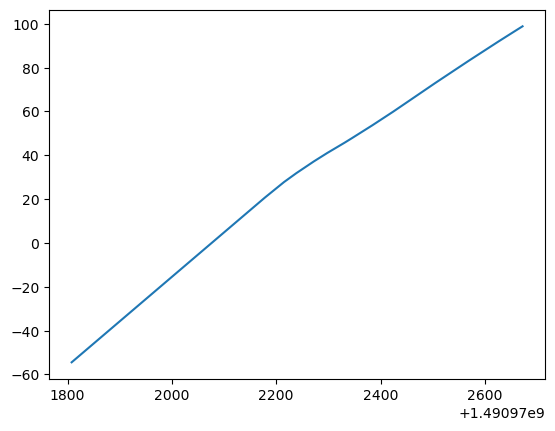

In [103]:
plt.plot(mlt_efr, func(mlt_efr))

In [16]:
func

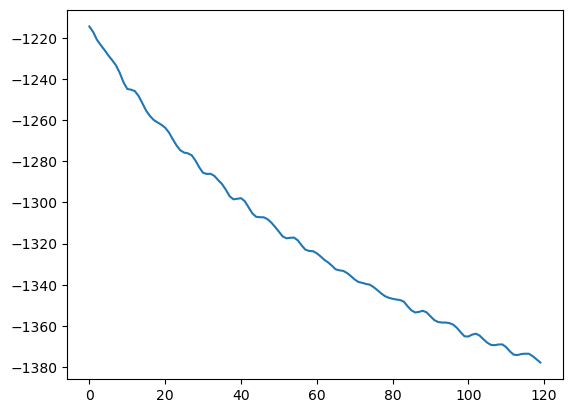

In [30]:
plt.plot(E1[:120])

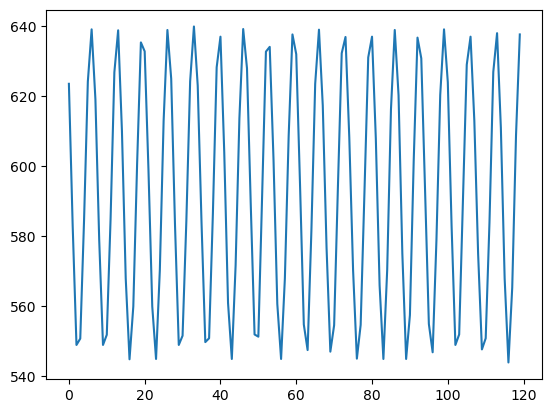

In [46]:
plt.plot(HX[:120])

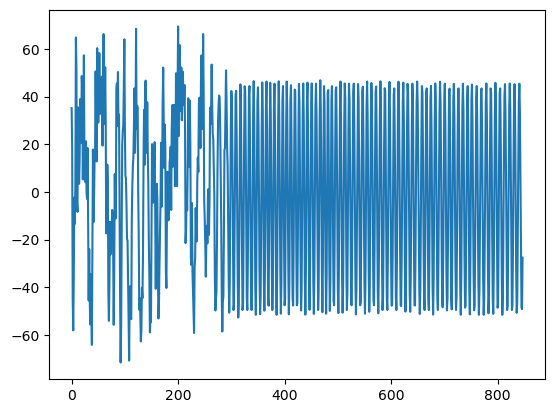

In [105]:
plt.plot(HX-np.mean(HX))

In [ ]:
data = HX-np.mean(HX)

optimize_func = lambda x: x[0]*np.sin(x[1]*seqno+x[2]) + x[3] - data

np.linalg.lstsq(BASIS, e1, rcond=None)



In [51]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

[-36.31552061   0.77096949   4.49397758  -1.27299911]


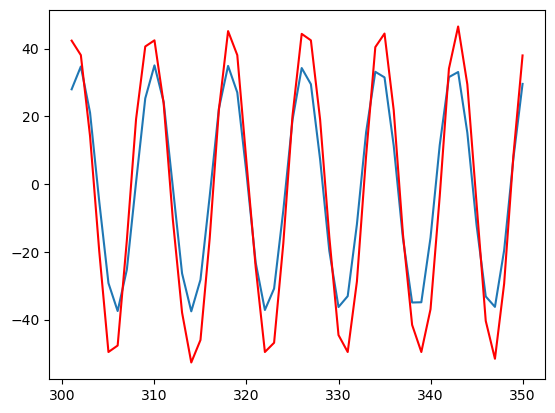

In [107]:
from scipy.optimize import curve_fit as cf
import numpy as np
from matplotlib import pyplot as plt

# simulate your data
data = HX-np.mean(HX)

xdata = seqno
ydata = data

# sin function needs a y-offset -> c
def sin_fun(x,a,b,c,d):
    return a*np.sin(b*x+c)+d

# need a reasonable guess -> note that the guess is not quite right but curve_fit still works
lind = len(xdata)//2-150
uind = len(xdata)//2+150
p_opt,p_cov=cf(sin_fun,xdata[lind:lind+100],ydata[lind:lind+100], p0=(40, 2*np.pi/8, 0, 0))
print(p_opt)

plt.plot(xdata[300:350],sin_fun(xdata,*p_opt)[300:350])
plt.plot(xdata[300:350],ydata[300:350], 'r', ms=1)
plt.show()

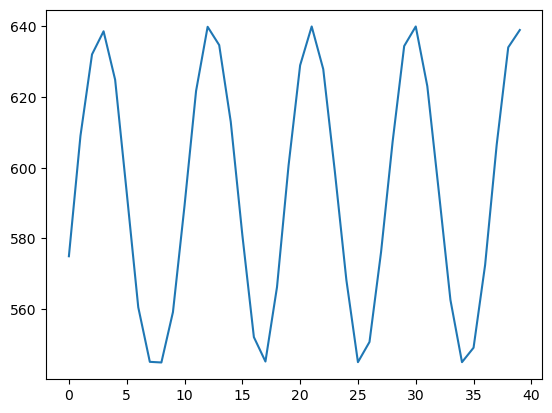

In [60]:
plt.plot(HX[100:140])

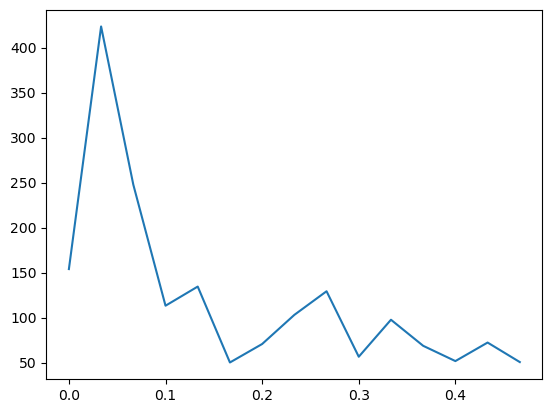

In [88]:
ff = np.fft.fftfreq(len(seqno[:50]), (seqno[1]-seqno[0]))   # assume uniform spacing
Fyy = abs(np.fft.fft(data[:50]))
plt.plot(ff[:len(ff)//2], Fyy[:len(ff)//2])

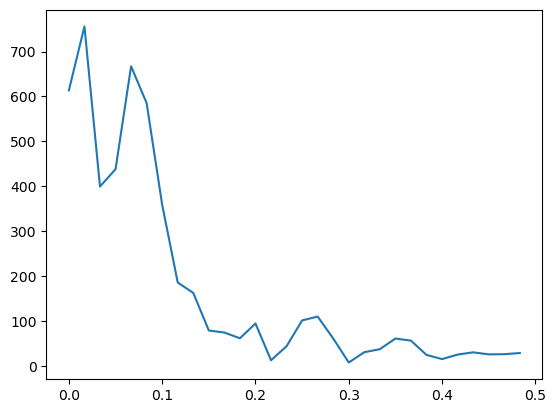

In [93]:
ff = np.fft.fftfreq(len(seqno[35:95]), (seqno[1]-seqno[0]))   # assume uniform spacing
Fyy = abs(np.fft.fft(data[35:95]))
plt.plot(ff[:len(ff)//2], Fyy[:len(ff)//2])
peak_freq = abs(ff[np.argmax(Fyy[1:])+1])  

In [94]:
peak_freq

0.016666666666666666

In [96]:
mlt_efr[80]

1490879932.2426963

In [99]:
np.where(Pef-8.11132812<0.0001)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112]),)

In [100]:
mlt_efr[112]

1490879964.8894374